First we must import numpy and SINDy

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pysindy import SINDy
from pysindy.feature_library import *
from pysindy.differentiation import *
# from pysindy.optimizers import *
from scipy.integrate import odeint, solve_ivp

# Import reduced dataset
file = '../ReducedTorqueData.csv'
data = np.loadtxt(file, delimiter=',', skiprows=1)#, max_rows=100000)
pd.read_csv(file, nrows=3)

,timeInS,i_aInA,i_bInA,i_cInA,u_aInV,u_bInV,u_cInV,epsilon_elInRad
0,0.000000,1.765625,3.453125,0.937500,-0.322917,-0.677083,1.000000,-2.403804
1,0.000001,1.578125,3.421875,0.859375,-0.177083,-0.750000,0.927083,-2.403765
2,0.000002,1.578125,3.562500,0.750000,-0.114583,-0.854167,0.968750,-2.403726


In [28]:
# Given Parameters
n_me = 16.67    # Hz
U_DC = 294      # Volts DC
Rs = 18e-3      # Ohms
Ld = 370e-6     # Henry
Lq = 1200e-6    # Henry
psi_p = 66e-3   # Vs
i_dqmax = 240   # Amps
p = 3           # pole pair number

In [29]:
# Split data and calculate X_dq
t = data[:, 0]
i_abc = data[:, 1:4]
u_abc = data[:, 4:7]
e = data[:, 7]

i_dq = np.zeros((len(data), 2))
u_dq = np.zeros((len(data), 2))
for i in range(len(data)):
    trig = np.array([[np.cos(e[i]), -np.cos(e[i] + np.pi/3), -np.cos(e[i] - np.pi/3)],
                    [-np.sin(e[i]), np.sin(e[i] + np.pi/3), np.sin(e[i] - np.pi/3)]])
    i_dq[i] = np.matmul(trig, i_abc[i])
    u_dq[i] = np.matmul(trig, u_abc[i])

psi_d = Ld*i_dq[:, 0] + psi_p
psi_q = Lq*i_dq[:, 1]
T = 1.5*p*(psi_d*i_dq[:, 1] - psi_q*i_dq[:, 0])

X = np.column_stack((T, 
                     i_dq, 
                     u_dq, 
                     np.sin(e), 
                     np.cos(e)
                     ))


In [30]:
# Instantiate model
model = SINDy(
              # feature_library=PolynomialLibrary(degree=1),
              feature_library=FourierLibrary(n_frequencies=1),
              # feature_library=WeakPDELibrary(),
              differentiation_method=SmoothedFiniteDifference(),
              feature_names=['T',
                             'i_d','i_q',
                             'u_d','u_q',
                             'sin(e)','cos(e)'
                             ]
            )

model.fit(X, t=t)
model.print()
model.coefficients()
model.score(X, t=t[1]-t[0])

(T)' = -8259.744 sin(1 T) + 2102.437 cos(1 T) + -1146.000 sin(1 i_d) + -514.394 cos(1 i_d) + -1415.667 sin(1 i_q) + 178.600 cos(1 i_q) + -744.976 sin(1 u_d) + -635.663 cos(1 u_d) + -989.887 sin(1 u_q) + -806.027 cos(1 u_q) + -940.012 sin(1 sin(e)) + -4364.317 cos(1 sin(e)) + 1245.350 sin(1 cos(e)) + -4294.719 cos(1 cos(e))
(i_d)' = 45444.144 sin(1 T) + -5324.934 cos(1 T) + 1009.047 sin(1 i_d) + -474.771 cos(1 i_d) + 7879.859 sin(1 i_q) + 317.101 cos(1 i_q) + 785.568 sin(1 u_d) + -1726.405 cos(1 u_d) + 2162.858 sin(1 u_q) + 1003.381 cos(1 u_q) + 869.783 sin(1 sin(e)) + 25924.854 cos(1 sin(e)) + -468.836 sin(1 cos(e)) + 25235.595 cos(1 cos(e))
(i_q)' = -28852.740 sin(1 T) + 6991.822 cos(1 T) + -3876.934 sin(1 i_d) + -1748.010 cos(1 i_d) + -5004.253 sin(1 i_q) + 527.087 cos(1 i_q) + -2557.798 sin(1 u_d) + -2143.446 cos(1 u_d) + -3362.449 sin(1 u_q) + -2742.801 cos(1 u_q) + -3222.354 sin(1 sin(e)) + -15223.217 cos(1 sin(e)) + 4212.059 sin(1 cos(e)) + -14982.172 cos(1 cos(e))
(u_d)' = -1427

0.286465201325181

In [31]:
tspan = [t[0], t[-1]]
X0 = X[0]
# x_SINDy = solve_ivp(model, tspan, X0, t_eval=t)
sim = model.simulate(X0, t=t)               # sim should match X if there was no error
print(sim)

[[-5.72774341e-01 -1.14748849e+00 -1.90109925e+00 ...  7.48895897e-01
  -6.72653255e-01 -7.39957836e-01]
 [-5.73374738e-01 -1.14386068e+00 -1.90323620e+00 ...  8.61059242e-01
  -6.72682469e-01 -7.39930954e-01]
 [-5.73926770e-01 -1.14002248e+00 -1.90521009e+00 ...  8.73668921e-01
  -6.72711705e-01 -7.39904091e-01]
 ...
 [-7.76825228e+00  2.08523592e+03 -8.71570204e+01 ... -5.46601275e+05
  -4.01385985e-01  3.38260038e-01]
 [-7.76749571e+00  2.08523950e+03 -8.71546065e+01 ... -5.46602947e+05
  -4.01368540e-01  3.38276661e-01]
 [-7.76806802e+00  2.08524572e+03 -8.71567056e+01 ... -5.46604007e+05
  -4.01350380e-01  3.38293104e-01]]


In [32]:
T_SINDy = sim[:,0]

# psi_d = Ld*sim[:,0] + psi_p
# psi_q = Lq*sim[:,1]
# T_SINDy = 1.5*p*(psi_d*sim[:,1] - psi_q*sim[:, 0])
# T_SINDy

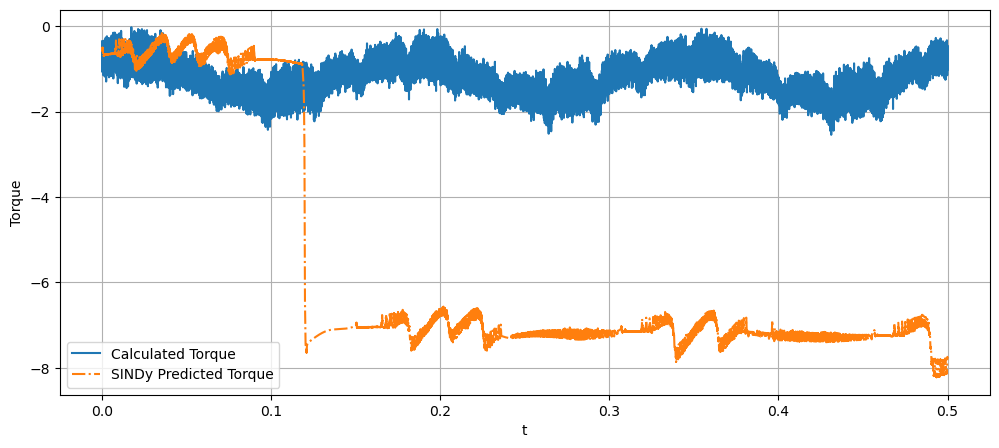

In [33]:
plt.figure(figsize=(12,5))
plt.plot(t, T, '-', t, T_SINDy, '-.')
plt.xlabel('t')
plt.ylabel('Torque')
plt.legend(['Calculated Torque','SINDy Predicted Torque'])
plt.grid()
plt.show()

In [34]:
# # Define weak form ODE library
# # defaults to derivative_order = 0 if not specified,
# # and if spatial_grid is not specified, defaults to None,
# # which allows weak form ODEs.
# library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
# library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]
# ode_lib = ps.WeakPDELibrary(
#     library_functions=library_functions,
#     function_names=library_function_names,
#     spatiotemporal_grid=t_train,
#     is_uniform=True,
#     K=100,
# )